In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from pathlib import Path

import glob
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset  
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim

import cv2
from matplotlib.image import imread

import tensorflow as tf
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import glob
import PIL
import random

random.seed(100)

Num GPUs Available:  1


In [3]:
breast_img_paths = glob.glob('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png', recursive = True)
for img_path in breast_img_paths[:5]:
    print(img_path)

/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-006.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-011.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-004.png


In [4]:
benign = []
malignant = []
# subtypes
A, F, PT, TA = [], [], [], [] # subtypes for benign
DC, LC, MC, PC = [], [], [], [] # subtypes for malignant

for img in breast_img_paths:
    img_name = Path(img).name
    if img_name[6] == 'A':
        A.append(img)
    elif img_name[6] == 'F':
        F.append(img)
    elif img_name[6] == 'P'and img_name[7] == 'T':
        PT.append(img)
    elif img_name[6] == 'T':
        TA.append(img)
    elif img_name[6] == 'D':
        DC.append(img)
    elif img_name[6] == 'L':
        LC.append(img)
    elif img_name[6] == 'M':
        MC.append(img)
    elif img_name[6] == 'P':
        PC.append(img)
    
    if img_name[4] == 'B':
        benign.append(img)
    else:
        malignant.append(img)
    

In [5]:
print("Total examples: ", len(breast_img_paths))
print("Number of benign examples", len(benign))
print("Number of malignant examples", len(malignant))

Total examples:  7909
Number of benign examples 2480
Number of malignant examples 5429


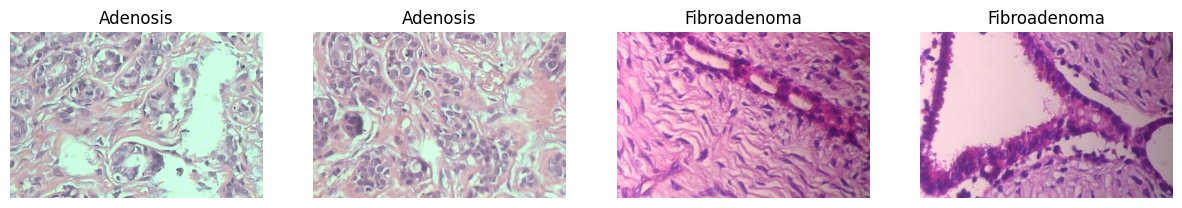

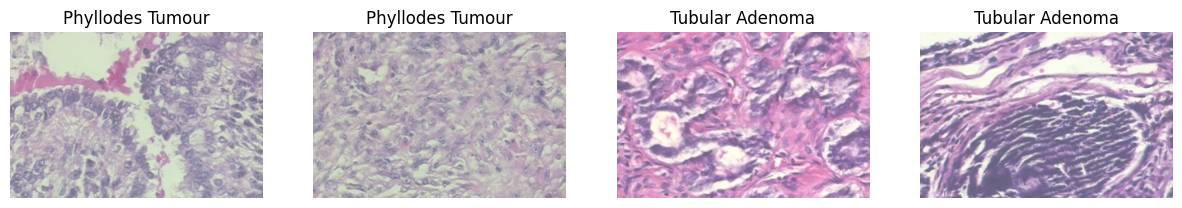

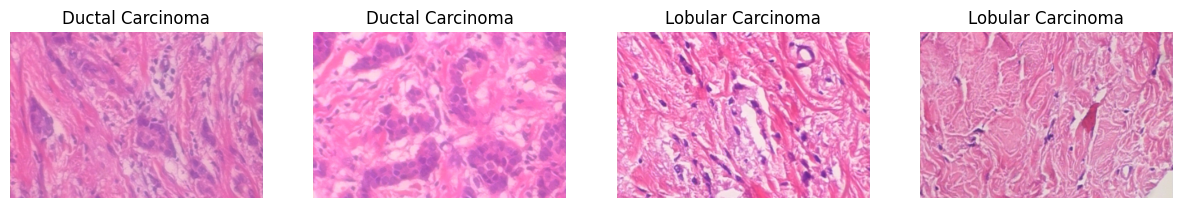

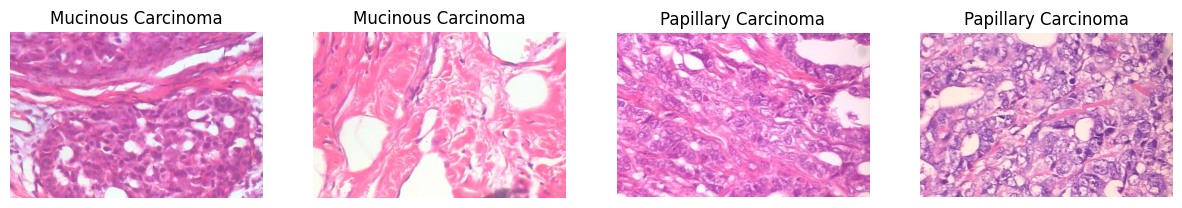

In [6]:
import matplotlib.image as mpimg

def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, img_path in zip(axes[:2], list1[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label1)  
        ax.axis('off')
    
    for ax, img_path in zip(axes[2:], list2[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label2)
        ax.axis('off')
    plt.show()
display_images("Adenosis", "Fibroadenoma", A, F)
display_images("Phyllodes Tumour","Tubular Adenoma", PT, TA)
display_images("Ductal Carcinoma","Lobular Carcinoma", DC, LC)
display_images("Mucinous Carcinoma","Papillary Carcinoma", MC, PC)

# PREPROCESSING

In [7]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    for img in img_list:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = image / 255.0
        if label != 4:
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
        else:
            image_resized = tf.image.resize(image, size)
            img_array.append([image_resized, label])

    return img_array

def augment_image(img):
    augmented_images = []

    augmented_images.append(img)

    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)

    return augmented_images

#benign subtypes
A_imgs  = load_and_resize_images(A, 0) #adenosis
F_imgs  = load_and_resize_images(F, 1) #fibroadenoma
PT_imgs  = load_and_resize_images(PT, 2) #phyllodes
TA_imgs = load_and_resize_images(TA, 3) #tubular 
#malignant subtypes 
DC_imgs = load_and_resize_images(DC, 4) #ductal
LC_imgs = load_and_resize_images(LC, 5) #lobular
MC_imgs = load_and_resize_images(MC, 6) #mucinous
PC_imgs = load_and_resize_images(PC, 7) #papillary

In [8]:
benign_images = A_imgs + F_imgs + PT_imgs + TA_imgs 
malignant_images = DC_imgs + LC_imgs + MC_imgs + PC_imgs
print("Total number of benign examples:", len(benign_images))
print("Total number of malignant examples:", len(malignant_images))


Total number of benign examples: 7440
Total number of malignant examples: 9385


# DATASET SPLIT

In [10]:
random.shuffle(benign_images)
random.shuffle(malignant_images)

In [11]:
train_benign, test_benign = train_test_split(benign_images, test_size=0.2, random_state=42)

train_benign, val_benign = train_test_split(train_benign, test_size=0.25, random_state=42)

In [12]:
train_malignant, test_malignant = train_test_split(malignant_images, test_size=0.2, random_state=42)

train_malignant, val_malignant = train_test_split(train_malignant, test_size=0.25, random_state=42)

In [13]:
train_benign_modified = [(image, 0) for image, label in train_benign]
train_malignant_modified = [(image, 1) for image, label in train_malignant]

train_data = train_benign_modified + train_malignant_modified
random.shuffle(train_data)

In [14]:
val_benign_modified = [(image, 0) for image, label in val_benign]
val_malignant_modified = [(image, 1) for image, label in val_malignant]

val_data = val_benign_modified + val_malignant_modified
random.shuffle(val_data)

In [15]:
test_benign_modified = [(image, 0) for image, label in test_benign]
test_malignant_modified = [(image, 1) for image, label in test_malignant]

test_data = test_benign_modified + test_malignant_modified

In [16]:
print("Total number of examples:", len(train_data) + len(val_data) + len(test_data))

Total number of examples: 16825


In [17]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  
    labels = np.array(labels)
    
    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=2)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

with tf.device('/GPU:0'):
    train_dataset = create_tf_dataset(train_data)
    val_dataset = create_tf_dataset(val_data)
    test_dataset = create_tf_dataset(test_data)

# BINARY CLASS

In [18]:
# Base Model - DenseNet121
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

layer_names = ['conv3_block12_concat', 'conv4_block24_concat', 'conv5_block16_concat']
intermediate_outputs = [base_model.get_layer(name).output for name in layer_names]

intermediate_model = Model(inputs=base_model.input, outputs=intermediate_outputs)

branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

fusion = tf.keras.layers.Concatenate()(branch_outputs)

x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(2, activation='softmax')(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
binary_model = Model(inputs=base_model.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

binary_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [22]:
import time

start_time = time.time()

history = binary_model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=50,
                           callbacks=[early_stopping, reduce_lr])

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 237s 679ms/step - accuracy: 0.7670 - loss: 0.9015 - val_accuracy: 0.5578 - val_loss: 1.0617 - learning_rate: 1.0000e-04
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9290 - loss: 0.5493 - val_accuracy: 0.7031 - val_loss: 0.8599 - learning_rate: 1.0000e-04
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9588 - loss: 0.4549 - val_accuracy: 0.7994 - val_loss: 0.7399 - learning_rate: 1.0000e-04
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9779 - loss: 0.3940 - val_accuracy: 0.8871 - val_loss: 0.5767 - learning_rate: 1.0000e-04
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9810 - loss: 0.3671 - val_accuracy: 0.9453 - val_loss: 0.4559 - learning_rate: 1.0000e-04
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9895 - loss: 0.3344 - val_accuracy: 0.8942 - val_loss: 0.5992 - learning_rate: 1.0000e-04
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 1

In [31]:
test_loss, test_acc = binary_model.evaluate(test_dataset)
print(f"Test accuracy (binary classification): {test_acc:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9858 - loss: 0.1092
Test accuracy (binary classification): 0.9863


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = binary_model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1) 
    true_classes = np.argmax(labels, axis=1)

    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
auc_score = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {auc_score:.4f}")

Precision: 0.9888
Recall: 0.9867
F1 Score: 0.9877
ROC-AUC: 0.9863


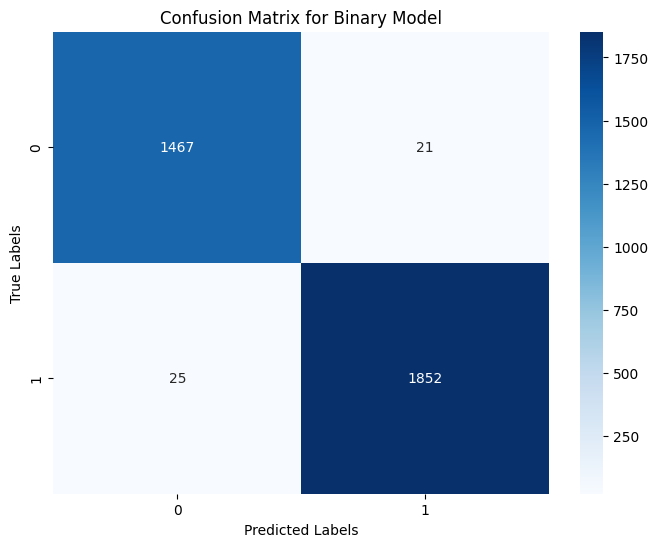

In [26]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Binary Model')
plt.show()

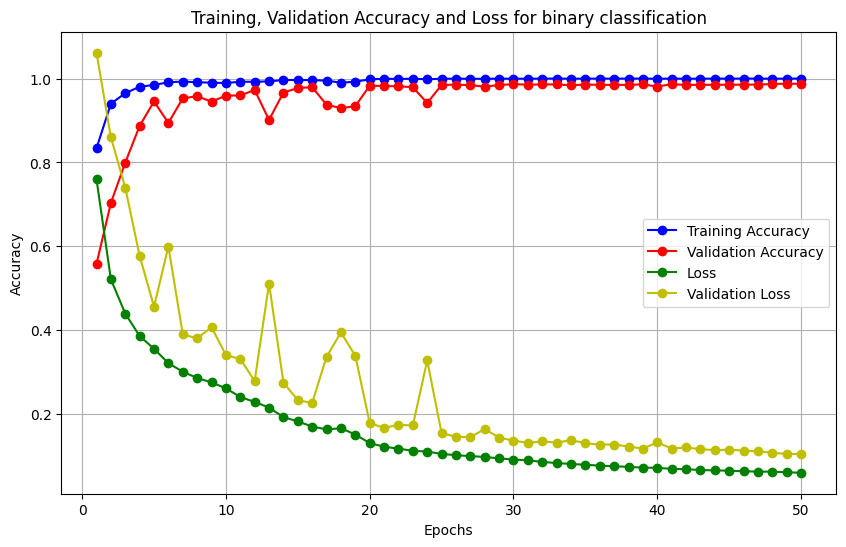

In [38]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.plot(epochs, train_loss, 'go-', label='Loss')
plt.plot(epochs, val_loss, 'yo-', label='Validation Loss')
plt.title('Training, Validation Accuracy and Loss for binary classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# MULTICLASS

In [18]:
train_malignant1 = [(image, label-4) for image, label in train_malignant]
val_malignant1 = [(image, label-4) for image, label in val_malignant]
test_malignant1 = [(image, label-4) for image, label in test_malignant]

In [18]:
train_benign1 = [(image, label-4) for image, label in train_benign]
val_benign1 = [(image, label-4) for image, label in val_benign]
test_benign1 = [(image, label-4) for image, label in test_benign]

In [19]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images) 
    labels = np.array(labels)
    

    labels = tf.keras.utils.to_categorical(labels, num_classes=4)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [20]:
train_benign2 = create_tf_dataset(train_benign)
val_benign2 = create_tf_dataset(val_benign)
test_benign2 = create_tf_dataset(test_benign)
train_malignant2 = create_tf_dataset(train_malignant1)
val_malignant2 = create_tf_dataset(val_malignant1)
test_malignant2 = create_tf_dataset(test_malignant1)

In [21]:
base_model_b = tf.keras.applications.DenseNet121(
weights='imagenet',
include_top=False,
input_shape=(128, 128, 3)
)

layer_names = ['conv3_block12_concat', 'conv4_block24_concat', 'conv5_block16_concat']
intermediate_outputs = [base_model_b.get_layer(name).output for name in layer_names]

intermediate_model = Model(inputs=base_model_b.input, outputs=intermediate_outputs)

branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)

fusion = tf.keras.layers.Concatenate()(branch_outputs)

x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
benign_model = Model(inputs=base_model_b.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

benign_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [23]:
import time

start_time = time.time()

history_b = benign_model.fit(train_benign2,
                    validation_data=val_benign2,
                    epochs=50)

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.4250 - loss: 1.9936 - val_accuracy: 0.1821 - val_loss: 1.7658
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.7104 - loss: 1.0943 - val_accuracy: 0.1821 - val_loss: 1.7317
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.8227 - loss: 0.8502 - val_accuracy: 0.2144 - val_loss: 1.6589
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.8976 - loss: 0.6805 - val_accuracy: 0.4120 - val_loss: 1.5093
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9283 - loss: 0.6098 - val_accuracy: 0.5578 - val_loss: 1.3491
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9523 - loss: 0.5523 - val_accuracy: 0.7554 - val_loss: 1.0983
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9683 - loss: 0.5032 - val_accuracy: 0.8582 - val_loss: 0.8539
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9729 - loss: 0.4895 - val_accuracy: 0

In [24]:
test_loss, test_acc = benign_model.evaluate(test_benign2)
print(f"Test accuracy -multi class for benign-: {test_acc:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9375 - loss: 0.3931
Test accuracy -multi class for benign-: 0.9483


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns

y_true_b = []
y_pred_b = []

for images, labels in test_benign2:  
    predictions_b = benign_model.predict(images, verbose=0)
    predicted_classes_b = np.argmax(predictions_b, axis=1) 
    true_classes_b = np.argmax(labels, axis=1) 

    y_true_b.extend(true_classes_b)
    y_pred_b.extend(predicted_classes_b)

y_true_b = np.array(y_true_b)
y_pred_b = np.array(y_pred_b)

precision = precision_score(y_true_b, y_pred_b, average='macro')
recall = recall_score(y_true_b, y_pred_b, average='macro')
f1 = f1_score(y_true_b, y_pred_b, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9541
Recall: 0.9324
F1 Score: 0.9415


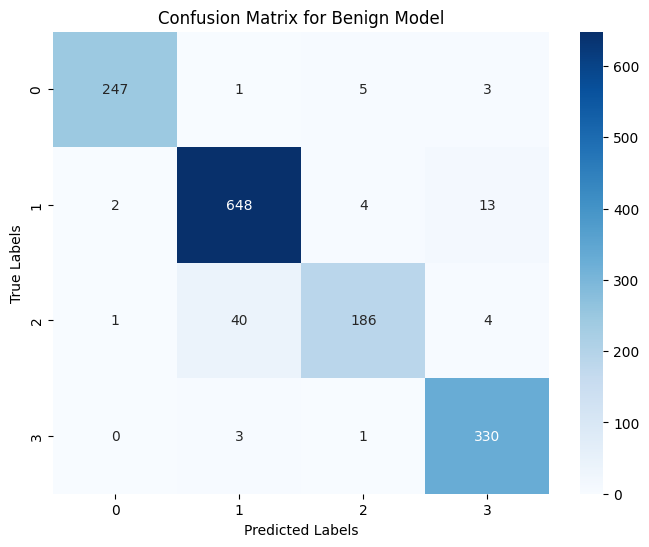

In [28]:
conf_matrix_b = confusion_matrix(y_true_b, y_pred_b)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Benign Model')
plt.show()

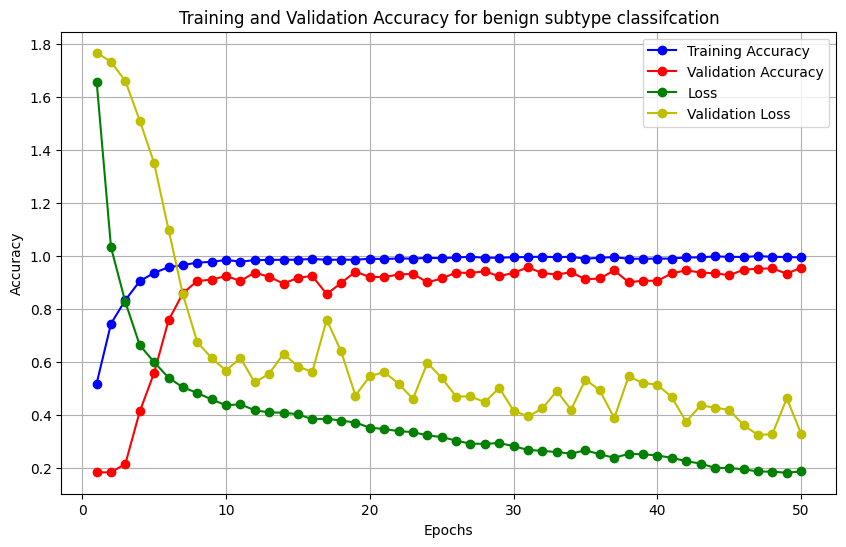

In [30]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc_b = history_b.history['accuracy']
val_acc_b = history_b.history['val_accuracy']
train_loss_b =  history_b.history['loss']
val_loss_b = history_b.history['val_loss']

# Create a list of epochs
epochs = range(1, len(train_acc_b) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_b, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_b, 'ro-', label='Validation Accuracy')
plt.plot(epochs, train_loss_b, 'go-', label='Loss')
plt.plot(epochs, val_loss_b, 'yo-', label='Validation Loss')
plt.title('Training and Validation Accuracy for benign subtype classifcation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# MALIGNANT 

In [31]:
base_model_m = tf.keras.applications.DenseNet121(
weights='imagenet',
include_top=False,
input_shape=(128, 128, 3)
)
# base_model_m.trainable = False #freezing the DenseNet121 layers

# Extract intermediate layers
layer_names = ['conv3_block12_concat', 'conv4_block24_concat', 'conv5_block16_concat']
intermediate_outputs = [base_model_m.get_layer(name).output for name in layer_names]

intermediate_model = Model(inputs=base_model_m.input, outputs=intermediate_outputs)

# Define the branches for each intermediate output
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)
# Concatenate the branch outputs for score-level fusion
fusion = tf.keras.layers.Concatenate()(branch_outputs)

x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(4, activation='softmax')(x)

In [32]:
malignant_model = Model(inputs=base_model_m.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

malignant_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [33]:
import time

start_time = time.time()

history_m = malignant_model.fit(train_malignant2,
                                validation_data=val_malignant2,
                                epochs=50)

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4195 - loss: 1.8211 - val_accuracy: 0.3245 - val_loss: 1.7526
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.6639 - loss: 1.1917 - val_accuracy: 0.3372 - val_loss: 1.6917
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.7738 - loss: 0.9701 - val_accuracy: 0.4699 - val_loss: 1.5461
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8438 - loss: 0.8069 - val_accuracy: 0.7027 - val_loss: 1.3365
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.8935 - loss: 0.6973 - val_accuracy: 0.8556 - val_loss: 1.0486
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9366 - loss: 0.6091 - val_accuracy: 0.8737 - val_loss: 0.8203
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9547 - loss: 0.5531 - val_accuracy: 0.8663 - val_loss: 0.7374
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9626 - loss: 0.5190 - val_accura

In [34]:
test_loss, test_acc = malignant_model.evaluate(test_malignant2)
print(f"Test accuracy -multi class for malignant-: {test_acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9254 - loss: 0.3920
Test accuracy -multi class for malignant-: 0.9254


In [35]:
y_true_m = []
y_pred_m = []

for images, labels in test_malignant2:  
    # Predict the classes for each image
    predictions_m = malignant_model.predict(images, verbose=0)
    predicted_classes_m = np.argmax(predictions_m, axis=1)
    true_classes_m = np.argmax(labels, axis=1)

    y_true_m.extend(true_classes_m)
    y_pred_m.extend(predicted_classes_m)

y_true_m = np.array(y_true_m)
y_pred_m = np.array(y_pred_m)

# Compute precision, recall, and F1 score for multi-class classification
precision = precision_score(y_true_m, y_pred_m, average='macro')
recall = recall_score(y_true_m, y_pred_m, average='macro')
f1 = f1_score(y_true_m, y_pred_m, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9318
Recall: 0.9193
F1 Score: 0.9251


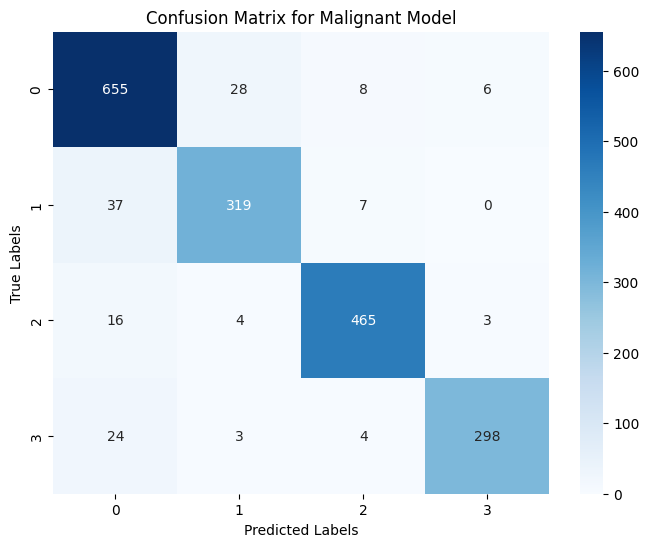

In [36]:
conf_matrix_m = confusion_matrix(y_true_m, y_pred_m)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_m, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Malignant Model')
plt.show()

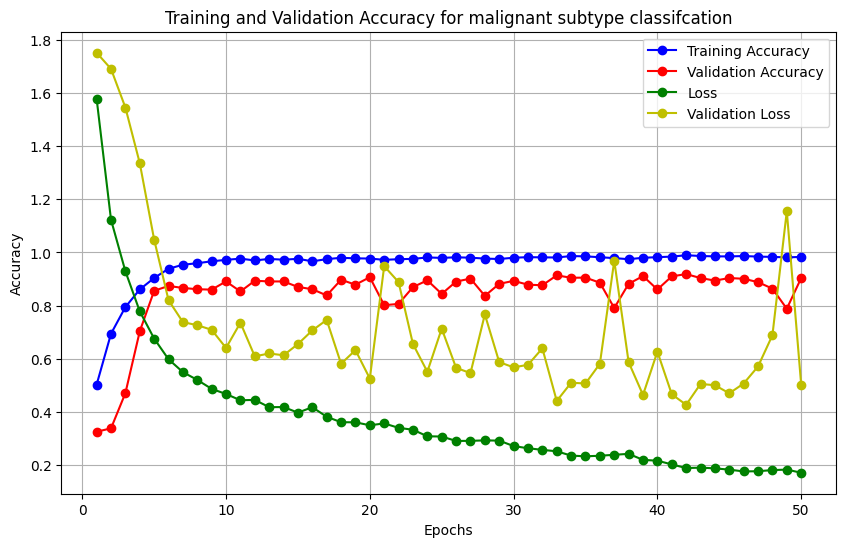

In [37]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc_m = history_m.history['accuracy']
val_acc_m = history_m.history['val_accuracy']
train_loss_m =  history_m.history['loss']
val_loss_m = history_m.history['val_loss']

# Create a list of epochs
epochs = range(1, len(train_acc_b) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_m, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_m, 'ro-', label='Validation Accuracy')
plt.plot(epochs, train_loss_m, 'go-', label='Loss')
plt.plot(epochs, val_loss_m, 'yo-', label='Validation Loss')
plt.title('Training and Validation Accuracy for malignant subtype classifcation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()